# 主双対法による制約付きMDPの解法

参考

* [Exploration-Exploitation in Constrained MDPs](https://arxiv.org/abs/2003.02189)
* [CONSTRAINED MARKOV DECISION PROCESSES](https://www-sop.inria.fr/members/Eitan.Altman/TEMP/h.pdf)

[前回](RL_CMDP_explore_exploit.ipynb)は線型計画法によってCMDPを解く方法を見ました．
今回は主双対法をみます．

![OptDual](figs/OptPrimalDual-CMDP.png)


準備：
* Optimisticな制約違反： $\widetilde{g}_k =\left({D}_k q^{\pi_k}\left(\widetilde{p}_k\right)-\alpha\right)$
* 真の制約違反： $g_k =\left(D q^{\pi_k}(p)-\alpha\right)$
* Optimisticな価値：$\tilde{f}_k={c}_k^T q^{\pi_k}\left(\widetilde{p}_k\right)$
* 真の価値：$f_k=c^T q^{\pi_k}$
* 最適価値：$f_{o p t}=V_1^*\left(s_1\right)=c^T q^*$

また，次のFailure Eventを考えます（LPのときとだいたい同じです）．

$$
\begin{aligned}
& F_k^p=\left\{\exists s, a, s^{\prime}, h:\left|p_h\left(s^{\prime} \mid s, a\right)-\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right)\right| \geq \beta_{h, k}^p\left(s, a, s^{\prime}\right)\right\} \\
& F_k^N=\left\{\exists s, a, h: n_h^{k-1}(s, a) \leq \frac{1}{2} \sum_{j<k} q_h^{\pi_k}(s, a \mid p)-H \ln \frac{S A H}{\delta^{\prime}}\right\}
\end{aligned}
$$

前回同様，Failure Eventに対して、
$\bar{G}=F^p \bigcup F^N$の補集合としてGood Event$G$を定義します．
このGood Eventが成り立っているとき、[RL_UCB_VI_regret_proof.ipynb](RL_UCB_VI_regret_proof.ipynb)でやったような分散の変形を使うと，

$$
\left|\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right)-p_h\left(s^{\prime} \mid s, a\right)\right|=C_1 \sqrt{\frac{p_h\left(s^{\prime} \mid s, a\right) L_{\delta, p}}{n_h^k(s, a) \vee 1}}+\frac{C_2 L_{\delta, p}}{n_h^k(s, a) \vee 1}
$$

となる定数$C_1, C_2 > 0$が存在します。ここで$L_{\delta, p}=\ln \left(\frac{6 S A H K}{\delta}\right)$です。

これをつかってボーナスを報酬とコスト関数に乗せて，まず方策の評価をします：

* $\left\{Q_h^{\pi_k}\left(s, a ; \widetilde{c}_k, \bar{p}_{k-1}\right)\right\}_{s, a, h}=$ Trun. Policy Evaluation $\left(\widetilde{c}_k, \bar{p}_{k-1}, \pi_k\right)$
* $\forall i \in[I],\left\{Q_h^{\pi_k}\left(s, a ; \widetilde{d}_{i, k}, \bar{p}_{k-1}\right)\right\}_{s a h}=$ Trun. Policy Evaluation $\left(\widetilde{d}_i^k, \bar{p}_{k-1}, \pi_k\right)$

続いて，方策の更新を鏡像降下で実現します：

$$
\begin{aligned}
& Q_h^k(s, a)=Q_h^{\pi_k}\left(s, a ; \widetilde{c}_k, \bar{p}_{k-1}\right)+\sum_{i=1}^I \lambda_{k, i} Q_h^{\pi_k}\left(s, a ; \widetilde{d}_{k, i}, \bar{p}_{k-1}\right) \\
& \pi_h^{k+1}(a \mid s)=\frac{\pi_h^k(a \mid s) \exp \left(-t_K Q_h^k(s, a)\right)}{\sum_{a^{\prime}} \pi_h^k\left(a^{\prime} \mid s\right) \exp \left(-t_K Q_h^k\left(s, a^{\prime}\right)\right)}
\end{aligned}
$$



## ステップ１：On policy Optimality

Good eventが成立しているとき，任意の$k \in [K]$について，
$$
\sum_{k=1}^{K^{\prime}} \widetilde{f}_k+\lambda_k^T \widetilde{g}_k-f_{\pi^*}-\lambda_k^T g_{\pi^*} \leq \widetilde{\mathcal{O}}\left(\sqrt{H^4(1+I \rho)^2 K}\right)
$$

が成り立ちます．

**証明**

定義より，

$$
\begin{aligned}
& f_{\pi^*}+\lambda_k^T g_{\pi^*}=V_1^{\pi^*}\left(s_1 ; c, p\right)+\sum_{i=1}^I \lambda_{k, i} \left(V_1^{\pi^*}\left(s_1 ; d_i, p\right)- \alpha_i \right)\\
& \widetilde{f}_k+\lambda_k^T \widetilde{g}_k=\widehat{V}_1^{\pi_k}\left(s_1 ; \widetilde{c}_k, \bar{p}_k\right)+\sum_{i=1}^I \lambda_{k, i} \left(\widehat{V}_1^{\pi_k}\left(s_1 ; \widetilde{d}_{k, i}, \bar{p}_k\right)-\alpha_i\right) .
\end{aligned}
$$

です．

また，

$$
\begin{aligned}
Q_h^k(s, a) & :=Q_h^{\pi_k}\left(s, a ; \widetilde{c}_k, \bar{p}_{k-1}\right)+\sum_{i=1}^I \lambda_{k, i} Q_h^{\pi_k}\left(s, a ; \widetilde{d}_{k, i}, \bar{p}_{k-1}\right) \\
V_h^k\left(s_1\right) & :=\left\langle Q_h^k(s, \cdot), \pi_h^k\right\rangle .
\end{aligned}
$$

とします．ここで，$V-V$を変形して，

$$
\begin{aligned}
& \sum_{k=1}^{K^{\prime}} \widetilde{f}_k+\lambda_k^T \widetilde{g}_k-f_{\pi^*}-\lambda_k^T g_{\pi^*} \\
& =\sum_{k=1}^{K^{\prime}} V_1^k\left(s_1\right)-V_1^{\pi^*}\left(s_1 ; c+\lambda_k \widetilde{d}, p\right) \\
& =\underbrace{\sum_{k=1}^K \sum_{h=1}^H \mathbb{E}\left[\left\langle Q_h^k\left(s_h, \cdot\right), \pi_h^k\left(\cdot \mid s_h\right)-\pi_h^*\left(\cdot \mid s_h\right)\right\rangle \mid s_1=s_1, \pi^*, p\right]}_{(i)} \\
& +\sum_{k=1}^K \sum_{h=1}^H \mathbb{E}[\underbrace{Q_h^k\left(s_h, a_h\right)-c_h\left(s_h, a_h\right)-\sum_{i=1}^I \lambda_k d_{h, i}\left(s_h, a_h\right)-p_h\left(\cdot \mid s_h, a_h\right) V_{h+1}^k}_{(i i)} \mid s_1=s_1, \pi^*, p] .
\end{aligned}
$$

を得ます．(i)と(ii)をそれぞれバウンドします．

**(i)のバウンド（論文のLemma 25）**

これは[RL_useful_lemma.ipynb](RL_useful_lemma.ipynb)の **補題：オンラインのMirror descentをするときに便利**を使うと，

$$
\sum_{k=1}^K\left\langle Q_h^k(\cdot \mid s), \pi_h^k(\cdot \mid s)-\pi_h(\cdot \mid s)\right\rangle \leq \frac{\log A}{t_K}+\frac{t_K}{2} \sum_{k=1}^K \sum_a \pi_h^k(a \mid s)\left(Q_h^k(s, a)\right)^2
$$

であり，ここに$Q_h^k(s, a):=Q_h^{\pi_k}\left(s, a ; \widetilde{c}_k, \bar{p}_{k-1}\right)+\sum_{i=1}^I \lambda_{k, i} Q_h^{\pi_k}\left(s, a ; \widetilde{d}_{k, i}, \bar{p}_{k-1}\right)$を代入すれば，

$$
(i)=\sum_{k=1}^{K^{\prime}} \sum_{h=1}^H \mathbb{E}\left[\left\langle Q_h^k\left(s_h, \cdot\right), \pi_h^k\left(\cdot \mid s_h\right)-\pi_h^*\left(\cdot \mid s_h\right)\right\rangle \mid s_1=s_1, \pi^*, p\right] \lesssim \sqrt{H^4(1+I \rho)^2 K}
$$

であることがすぐにわかります．

**(ii)のバウンド（論文のLemma 26）**

こっちはOptimismを使うと０以下に抑えられます．（TODO: 詳細）

## ステップ２：Dual Optimism

こっから先は[RL_CMDP_explore_exploit_dual.ipynb](RL_CMDP_explore_exploit_dual.ipynb)と似たことをします．まず，

$$
\widetilde{f}_k-f_{o p t} \leq-\lambda_k^T \widetilde{g}_k+\left(\widetilde{f}_k+\lambda_k^T \widetilde{g}_k-f_{\pi^*}-\lambda_k^T g_{\pi^*}\right)
$$

を示します．これもだいたい同じなので省略．
後はだいたい同じです．

In [1]:
# 報酬の最大化＆効用を一定以上に保つ　ことを考えます
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple, Optional
from jax.random import PRNGKey

key = PRNGKey(0)

S = 10  # 状態集合のサイズ
A = 3  # 行動集合のサイズ
S_set = jnp.arange(S)  # 状態集合
A_set = jnp.arange(A)  # 行動集合
H = 10  # ホライゾン

# 報酬行列を適当に作ります
key, _ = jax.random.split(key)
rew = jax.random.uniform(key=key, shape=(H, S, A))
assert rew.shape == (H, S, A)


# 効用行列を適当に作ります
key, _ = jax.random.split(key)
utility = jax.random.uniform(key=key, shape=(H, S, A))
assert utility.shape == (H, S, A)


# 遷移確率行列を適当に作ります
key, _ = jax.random.split(key)
P = jax.random.uniform(key=key, shape=(H, S*A, S))
P = P / jnp.sum(P, axis=-1, keepdims=True)  # 正規化して確率にします
P = P.reshape(H, S, A, S)
np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します


# 初期状態分布を適当に作ります
key, _ = jax.random.split(key)
init_dist = jax.random.uniform(key, shape=(S,))
init_dist = init_dist / jnp.sum(init_dist)
np.testing.assert_allclose(init_dist.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します


# 状態集合, 行動集合, 割引率, 報酬行列, 遷移確率行列が準備できたのでMDPのクラスを作ります

class CMDP(NamedTuple):
    S_set: jnp.array  # 状態集合
    A_set: jnp.array  # 行動集合
    H: int  # ホライゾン
    rew: jnp.array  # 報酬行列
    utility: jnp.array  # 効用行列
    const: float  # 制約の閾値
    P: jnp.array  # 遷移確率行列
    init_dist: jnp.array  # 初期分布
    optimal_V_rew: Optional[jnp.ndarray] = None  # 報酬についての最適V値
    optimal_V_utility: Optional[jnp.ndarray] = None  # 効用についての最適V値

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_set)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_set)


const = 0.73 * H  # 制約は適当です。このときに実行可能である保証はとくにありません。
mdp = CMDP(S_set, A_set, H, rew, utility, const, P, init_dist)

print("状態数：", mdp.S)
print("行動数：", mdp.A)
print("ホライゾン：", mdp.H)
print("制約：", mdp.const)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


状態数： 10
行動数： 3
ホライゾン： 10
制約： 7.3


In [2]:
from functools import partial
import jax
import chex


@jax.jit
def compute_policy_Q(mdp: CMDP, policy: jnp.ndarray):
    """ベルマン期待作用素をホライゾン回走らせて価値関数を動的計画法で計算します。
    Args:
        mdp (CMDP)
        policy (np.ndarray): (HxSxA)の行列

    Returns:
        policy_Q_rew (jnp.ndarray): (HxSxA)の行列. 報酬関数についてのQ
        policy_Q_utility (jnp.ndarray): (HxSxA)の行列. コスト関数についてのQ
    """
    H, S, A = policy.shape

    def backup(i, args):
        policy_Q, g = args
        h = H - i - 1
        max_Q = (policy[h+1] * policy_Q[h+1]).sum(axis=1)
        next_v = mdp.P[h] @ max_Q
        chex.assert_shape(next_v, (S, A))
        policy_Q = policy_Q.at[h].set(g[h] + next_v)
        policy_Q = jnp.minimum(policy_Q, H - h)  # 後で便利なのでTruncationします
        return policy_Q, g
    
    policy_Q_rew = jnp.zeros((H+1, S, A))
    args = policy_Q_rew, mdp.rew
    policy_Q_rew, _ = jax.lax.fori_loop(0, mdp.H, backup, args)

    policy_Q_utility = jnp.zeros((H+1, S, A))
    args = policy_Q_utility, mdp.utility
    policy_Q_utility, _ = jax.lax.fori_loop(0, mdp.H, backup, args)
    return policy_Q_rew[:-1], policy_Q_utility[:-1]


uni_policy = jnp.ones((H, S, A)) / A
_ = compute_policy_Q(mdp, uni_policy)

In [3]:
from scipy.optimize import linprog
from itertools import product
B = np.zeros((H, S, A, H, S, A))

# 初期状態についての制約
for s, a in product(range(S), range(A)):
    B[0, s, a, 0, s] = 1


# 遷移についての制約
for h, s, a in product(range(1, H), range(S), range(A)):
    B[h, s, a, h, s] = 1  # sum_a d(h, s, a) を実現します
    B[h, s, a, h-1] = -mdp.P[h-1, :, :, s]  # sum_a d(h, s, a) を実現します


B = B.reshape((H*S*A, H*S*A))
mu = np.repeat(mdp.init_dist[:, None], A, axis=1).reshape(-1)
b = np.hstack((mu, np.zeros((H-1)*S*A)))

# コストについての制約
U = mdp.utility.reshape(1, -1)
u = np.array((mdp.const,))

r = - mdp.rew.reshape(-1)
lin_res = linprog(r, A_eq=B, b_eq=b, bounds=(0, None), A_ub=-U, b_ub=-u)

d_arr = lin_res.x.reshape(H, S, A)
np.testing.assert_allclose(d_arr.sum(axis=(1, 2)), 1.0, atol=1e-4)

In [4]:
# 行動の確率が全て０の箇所はUniformにします（この状態には訪れないことを意味しますが、NanがでちゃうのでUniformで回避します）
optimal_policy = d_arr / d_arr.sum(axis=-1, keepdims=True)
optimal_policy = jnp.where(jnp.isnan(optimal_policy), 1 / mdp.A, optimal_policy)
Q_rew, Q_utility = compute_policy_Q(mdp, optimal_policy)
V_rew, V_utility = (Q_rew * optimal_policy).sum(axis=-1), (Q_utility * optimal_policy).sum(axis=-1)

total_utility = V_utility[0] @ mdp.init_dist
assert total_utility >= mdp.const
print("最適方策の累積効用和", total_utility)

total_rew = V_rew[0] @ mdp.init_dist
print("最適方策の累積報酬和", total_rew)

mdp = mdp._replace(optimal_V_rew=V_rew, optimal_V_utility=V_utility)

最適方策の累積効用和 7.3
最適方策の累積報酬和 6.1104264


In [5]:
from jax.random import PRNGKey
from functools import partial


@partial(jax.jit, static_argnames=("N",))
def sample_next_state(mdp: CMDP, N: int, key: PRNGKey, D: jnp.array):
    """ 遷移行列Pに従って次の状態をN個サンプルします
    Args:
        mdp (MDP)
        N (int): サンプルする個数
        key (PRNGKey)
        D (np.ndarray): 状態行動対の集合 [(h1, s1, a1), (h1, s2, a2), ...]

    Returns:
        new_key (PRNGKey)
        next_s_set (np.ndarray): (len(D) x N) の次状態の集合
        count_HSAS (jnp.ndarray): 各(ステップ, 状態, 行動, 次状態)のペアの出現回数を格納した(H x S x A x S) の行列
    """
    new_key, key = jax.random.split(key)
    keys = jax.random.split(key, num=len(D))

    @jax.vmap
    def choice(key, hsa):
        return jax.random.choice(key, mdp.S_set, shape=(N,), p=P[hsa[0], hsa[1], hsa[2]])

    next_s = choice(keys, D)

    # 集めたサンプルについて、(h, s, a, ns)が何個出たかカウントします。
    H, S, A, S = mdp.P.shape
    count_HSAS = jnp.zeros((H*S*A, S))
    count_D_next_S = jax.vmap(lambda next_s: jnp.bincount(next_s, minlength=S, length=S))(next_s)
    D_ravel = jnp.ravel_multi_index(D.T, (H, S, A), mode="wrap")
    count_HSAS = count_HSAS.at[D_ravel].add(count_D_next_S)
    count_HSAS = count_HSAS.reshape(H, S, A, S)
    return new_key, next_s, count_HSAS

In [6]:
@jax.jit
def collect_samples(mdp: CMDP, key: PRNGKey, policy: jnp.array, init_s: int, epsilon: float=0.0):
    """ エピソードの開始から終了まで、MDPとインタラクションしてサンプルをH個集めます。qのε-貪欲方策に従って動きます。
    Args:
        mdp (MDP)
        H (int): ホライゾン
        key (PRNGKey)
        policy (jnp.ndarray): 方策
        init_s (int): 初期状態
        epsilon (float): ε-貪欲のパラメータ

    Returns:
        new_key (PRNGKey)
        count_HSAS (jnp.ndarray): 各(ステップ, 状態, 行動, 次状態)のペアの出現回数を格納した(H x S x A x S) の行列
    """
    H, S, A, S = mdp.P.shape
    chex.assert_shape(policy, (H, S, A))

    def body_fn(h, args):
        key, s, count_HSAS = args
        key, new_key = jax.random.split(key)
        act = jax.random.choice(new_key, A, p=policy[h, s])

        # 次状態をサンプルします
        key, new_key = jax.random.split(key)
        next_s = jax.random.choice(new_key, mdp.S_set, p=P[h, s, act])

        count_HSAS = count_HSAS.at[h, s, act, next_s].add(1)
        return key, next_s, count_HSAS

    count_HSAS = jnp.zeros((H, S, A, S))
    args = key, init_s, count_HSAS
    key, _, count_HSAS = jax.lax.fori_loop(0, H, body_fn, args)
    return key, count_HSAS

In [7]:
import matplotlib.pyplot as plt
from itertools import product
import chex
from jax.random import PRNGKey


def OptimalGreedyPolicy(mdp: CMDP, iteration: int):
    S, A, H = mdp.S, mdp.A, mdp.H
    key = PRNGKey(0)

    regrets_rew = []
    regrets_vio = []

    @jax.jit
    def compute_greedy_policy(Q: jnp.ndarray):
        """Q関数の貪欲方策を返します

        Args:
            Q (jnp.ndarray): (HxSxA)の行列

        Returns:
            greedy_policy (jnp.ndarray): (HxSxA)の行列
        """
        greedy_policy = jnp.zeros_like(Q)
        H, S, A = Q.shape
        
        def body_fn(i, greedy_policy):
            greedy_policy = greedy_policy.at[i, jnp.arange(S), Q[i].argmax(axis=-1)].set(1)
            return greedy_policy

        greedy_policy = jax.lax.fori_loop(0, H, body_fn, greedy_policy)
        chex.assert_shape(greedy_policy, (H, S, A))
        return greedy_policy


    @partial(jax.jit, static_argnames=("H", "S", "A"))
    def _compute_optimal_greedy_Q(mdp: CMDP, H: int, S: int, A: int):
        """ベルマン最適作用素をホライゾン回走らせて最適価値関数を動的計画法で計算します。
        制約は気にしません。
        Args:
            mdp (MDP)

        Returns:
            optimal_Q (jnp.ndarray): (HxSxA)の行列
        """

        def backup(i, optimal_Q):
            h = H - i - 1
            max_Q = optimal_Q[h+1].max(axis=1)
            next_v = mdp.P[h] @ max_Q
            chex.assert_shape(next_v, (S, A))
            optimal_Q = optimal_Q.at[h].set(mdp.rew[h] + next_v)
            return optimal_Q
        
        optimal_Q = jnp.zeros((H+1, S, A))
        optimal_Q = jax.lax.fori_loop(0, mdp.H, backup, optimal_Q)
        return optimal_Q[:-1]

    compute_optimal_Q = lambda mdp: _compute_optimal_greedy_Q(mdp, mdp.H, mdp.S, mdp.A)

    optimal_Q = compute_optimal_Q(mdp)
    policy = compute_greedy_policy(optimal_Q)

    for k in range(iteration):
        k = k + 1
        key, init_key = jax.random.split(key)
        init_s = jax.random.choice(init_key, S, p=mdp.init_dist)

        # リグレットを計算します（Reg+のほうです）
        Q_rew, Q_utility = compute_policy_Q(mdp, policy)
        total_rew = (Q_rew * policy)[0].sum(axis=-1)[init_s]
        total_utility = (Q_utility * policy)[0].sum(axis=-1)[init_s]
        
        reg_rew = jnp.maximum(mdp.optimal_V_rew[0][init_s] - total_rew, 0)
        reg_vio = jnp.maximum(mdp.const - total_utility, 0)

        regrets_rew.append(reg_rew)
        regrets_vio.append(reg_vio)

    return regrets_rew, regrets_vio


In [44]:
from functools import partial
import jax
import chex


def compute_bonus_mdp(mdp: CMDP, visit_HSAS: jnp.ndarray, P_approx: jnp.ndarray):
    # Bonusの計算
    visit_HSA = jnp.maximum(visit_HSAS.sum(axis=-1, keepdims=True), 1)
    Var = P_approx * (1 - P_approx)
    bonus = 0.01 * mdp.H * (jnp.sqrt(Var / visit_HSA) + 1 / visit_HSA)
    bonus = bonus.sum(axis=-1)

    bonus_rew = mdp.rew + bonus
    bonus_utility = mdp.utility + bonus

    bonus_mdp = mdp._replace(rew=bonus_rew, utility=bonus_utility, P=P_approx)
    return bonus_mdp


@jax.jit
def update_policy(Q, policy, tk):
    new_policy = jnp.zeros_like(Q)
    H, S, A = Q.shape
    
    def body_fn(i, new_policy):
        x = policy[i] * jnp.exp(tk * Q[i])
        new_policy = new_policy.at[i].set(x / x.sum(axis=-1, keepdims=True))
        return new_policy

    new_policy = jax.lax.fori_loop(0, H, body_fn, new_policy)
    chex.assert_shape(new_policy, (H, S, A))
    return new_policy


def PrimalDual(mdp: CMDP, iteration: int):
    S, A, H = mdp.S, mdp.A, mdp.H
    visit_HSAS = np.zeros((H, S, A, S))

    # ホントはHを知らないといけないけど今回は適当
    rho = 0.7 * H
    # tlam = jnp.sqrt(H ** 2 * iteration / rho ** 2)
    # tk = jnp.sqrt(2 * jnp.log(A) / (H ** 2 * (1 + rho) ** 2 * iteration))

    # ホントは学習率を調整しないといけないけど今回は適当
    tlam = 10.0
    tk = 0.1

    key = PRNGKey(0)

    regrets_rew = []
    regrets_vio = []

    policy = jnp.ones((H, S, A))
    policy = policy / policy.sum(axis=-1, keepdims=True)

    @jax.jit
    def sample_and_compute_regret(key, policy):
        # データのサンプルと遷移確率の更新をします
        key, init_key = jax.random.split(key)
        init_s = jax.random.choice(init_key, S, p=mdp.init_dist)
        key, count_HSAS = collect_samples(mdp, key, policy, init_s, epsilon=0.0)

        # リグレットを計算します（Reg+のほうです）
        Q_rew, Q_utility = compute_policy_Q(mdp, policy)
        total_rew = (Q_rew * policy)[0].sum(axis=-1)[init_s]
        total_utility = (Q_utility * policy)[0].sum(axis=-1)[init_s]
        
        reg_rew = jnp.maximum(mdp.optimal_V_rew[0][init_s] - total_rew, 0)
        reg_vio = jnp.maximum(mdp.const - total_utility, 0)

        return key, count_HSAS, reg_rew, reg_vio


    lam = 0.0
    for k in range(iteration):
        k = k + 1

        key, count_HSAS, reg_rew, reg_vio = sample_and_compute_regret(key, policy)
        visit_HSAS = visit_HSAS + count_HSAS
        regrets_rew.append(reg_rew.item())
        regrets_vio.append(reg_vio.item())

        visit_HSA = jnp.maximum(visit_HSAS.sum(axis=-1, keepdims=True), 1)
        P_approx = jnp.where(visit_HSAS.sum(axis=-1, keepdims=True) > 0, visit_HSAS / visit_HSA, 1 / S)

        # 方策評価をします
        bonus_mdp = compute_bonus_mdp(mdp, visit_HSAS, P_approx)
        Q_rew, Q_utility = compute_policy_Q(bonus_mdp, policy)
        Q = Q_rew + lam * Q_utility

        # 方策更新
        policy = update_policy(Q, policy, tk)

        # ラグランジュの更新
        total_utility = jnp.sum((Q_utility * policy)[0].sum(axis=-1) * mdp.init_dist)
        lam = max(lam + (mdp.const - total_utility) / tlam, 0)
        lam = min(lam, rho)
        # print((mdp.const - total_utility), lam)

    return regrets_rew, regrets_vio


In [45]:
iteration = 10000 

gr_regrets_rew, gr_regrets_vio = OptimalGreedyPolicy(mdp, iteration)
gr_regrets_rew = np.cumsum(gr_regrets_rew)
gr_regrets_vio = np.cumsum(gr_regrets_vio)

regrets_rew, regrets_vio = PrimalDual(mdp, iteration)
regrets_rew = np.cumsum(regrets_rew)
regrets_vio = np.cumsum(regrets_vio)


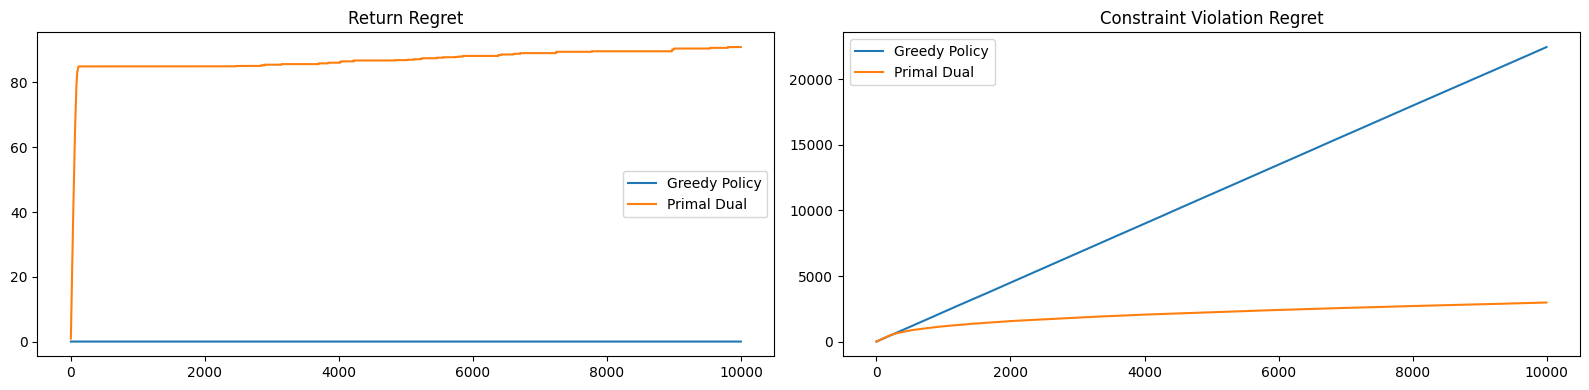

In [46]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.title("Return Regret")
plt.plot(gr_regrets_rew, label="Greedy Policy")
plt.plot(regrets_rew, label="Primal Dual")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Constraint Violation Regret")
plt.plot(gr_regrets_vio, label="Greedy Policy")
plt.plot(regrets_vio, label="Primal Dual")
plt.legend()

plt.tight_layout()